# Token Galaxy: Hero Plots for Mental 3D Reconstruction

**Goal:** Create two high-resolution views of the full token cloud that can be mentally stacked to visualize 3D structure.

**Both plots:**
- All 151,936 tokens (full vocabulary)
- Units in logometers (causal metric distances)
- Same physical scale (pixels per logometer)
- Same axis extents (can overlay with origins aligned)
- Colored by causal norm (radial distance from origin)

**Plot 1:** Dimensions 2559 × 2558 (two highest variance directions)  
**Plot 2:** Dimensions 2559 × 0 (highest × lowest variance)

**Interpretation:** These are orthogonal projections. Think of them as looking at a 3D object from two perpendicular angles, both at the same zoom level.

## Configuration

In [1]:
# Data paths
PROJECTIONS_PATH = '../data/vectors/token_eigenbasis_projections_qwen3_4b.pt'
EIGENBASIS_PATH = '../data/vectors/eigenbasis_qwen3_4b.pt'

# Plot parameters
FIGSIZE = (12, 12)  # Square plots, same size for both
DPI = 100
POINT_SIZE = 0.5
ALPHA = 0.4
CMAP = 'viridis'  # purple = close, yellow = far

print(f"Configuration:")
print(f"  Figure size: {FIGSIZE}")
print(f"  DPI: {DPI}")
print(f"  Point size: {POINT_SIZE}")
print(f"  Alpha: {ALPHA}")

Configuration:
  Figure size: (12, 12)
  DPI: 100
  Point size: 0.5
  Alpha: 0.4


## Setup

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [3]:
print("Loading data...\n")

# Load eigenbasis
print(f"Loading eigenbasis from {EIGENBASIS_PATH}...")
eigenbasis_data = torch.load(EIGENBASIS_PATH, weights_only=False)
eigenvalues = eigenbasis_data['eigenvalues'].numpy()  # [hidden_dim]

# Load token projections (ALL tokens)
print(f"Loading projections from {PROJECTIONS_PATH}...")
projections_data = torch.load(PROJECTIONS_PATH, weights_only=False)
projections = projections_data['projections'].numpy()  # [vocab_size, hidden_dim]

vocab_size, hidden_dim = projections.shape

print(f"\n✓ Data loaded")
print(f"  Vocab size: {vocab_size:,}")
print(f"  Hidden dim: {hidden_dim:,}")
print(f"\nEigenvalues for dimensions of interest:")
print(f"  Dimension 0 (smallest): {eigenvalues[0]:,.0f}")
print(f"  Dimension 2558 (3rd largest): {eigenvalues[2558]:,.0f}")
print(f"  Dimension 2559 (largest): {eigenvalues[2559]:,.0f}")

Loading data...

Loading eigenbasis from ../data/vectors/eigenbasis_qwen3_4b.pt...
Loading projections from ../data/vectors/token_eigenbasis_projections_qwen3_4b.pt...

✓ Data loaded
  Vocab size: 151,936
  Hidden dim: 2,560

Eigenvalues for dimensions of interest:
  Dimension 0 (smallest): 95
  Dimension 2558 (3rd largest): 73,918
  Dimension 2559 (largest): 94,218


## Compute Causal Norms

Calculate radial distance from origin for all tokens.

In [4]:
def compute_causal_norms(projections, eigenvalues):
    """
    Compute causal norms of projections in eigenbasis.
    
    Args:
        projections: [N, hidden_dim] array of eigenbasis coordinates
        eigenvalues: [hidden_dim] array of eigenvalues
    
    Returns:
        [N] array of causal norms (in logometers)
    """
    # ||v||_M = sqrt(sum_i lambda_i * v_i^2)
    weighted_squares = projections**2 * eigenvalues[np.newaxis, :]  # [N, hidden_dim]
    norms = np.sqrt(weighted_squares.sum(axis=1))  # [N]
    return norms

print("Computing causal norms for all tokens...")
causal_norms = compute_causal_norms(projections, eigenvalues)

print(f"\n✓ Causal norms computed")
print(f"\nRadial distance statistics:")
print(f"  Mean: {causal_norms.mean():.2f} logometers")
print(f"  Median: {np.median(causal_norms):.2f} logometers")
print(f"  Std: {causal_norms.std():.2f} logometers")
print(f"  Min: {causal_norms.min():.2f} logometers")
print(f"  Max: {causal_norms.max():.2f} logometers")

Computing causal norms for all tokens...

✓ Causal norms computed

Radial distance statistics:
  Mean: 54.13 logometers
  Median: 55.26 logometers
  Std: 7.90 logometers
  Min: 21.35 logometers
  Max: 85.29 logometers


## Convert to Logometer Coordinates

Scale eigenbasis projections to proper distance units.

In [5]:
def convert_to_logometers(projections, dim_r, dim_s, eigenvalues):
    """
    Convert eigenbasis projections to logometer coordinates for 2D plane.
    
    Args:
        projections: [N, hidden_dim] array
        dim_r: first dimension index
        dim_s: second dimension index
        eigenvalues: [hidden_dim] array
    
    Returns:
        r_logo: [N] array of r-coordinates in logometers
        s_logo: [N] array of s-coordinates in logometers
    """
    # Scale by sqrt(eigenvalue) to get logometer units
    r_logo = projections[:, dim_r] * np.sqrt(eigenvalues[dim_r])
    s_logo = projections[:, dim_s] * np.sqrt(eigenvalues[dim_s])
    return r_logo, s_logo

print("Converting to logometer coordinates...\n")

# Plot 1: 2559 × 2558
r1, s1 = convert_to_logometers(projections, 2559, 2558, eigenvalues)
print(f"Plot 1 (2559 × 2558):")
print(f"  Dim 2559 range: [{r1.min():.2f}, {r1.max():.2f}] logometers (width: {r1.max()-r1.min():.2f})")
print(f"  Dim 2558 range: [{s1.min():.2f}, {s1.max():.2f}] logometers (width: {s1.max()-s1.min():.2f})")

# Plot 2: 2559 × 0
r2, s2 = convert_to_logometers(projections, 2559, 0, eigenvalues)
print(f"\nPlot 2 (2559 × 0):")
print(f"  Dim 2559 range: [{r2.min():.2f}, {r2.max():.2f}] logometers (width: {r2.max()-r2.min():.2f})")
print(f"  Dim 0 range: [{s2.min():.2f}, {s2.max():.2f}] logometers (width: {s2.max()-s2.min():.2f})")

print("\n✓ Conversion complete")

Converting to logometer coordinates...

Plot 1 (2559 × 2558):
  Dim 2559 range: [-32.34, -5.77] logometers (width: 26.57)
  Dim 2558 range: [-8.33, 9.35] logometers (width: 17.68)

Plot 2 (2559 × 0):
  Dim 2559 range: [-32.34, -5.77] logometers (width: 26.57)
  Dim 0 range: [-7.86, 7.09] logometers (width: 14.95)

✓ Conversion complete


## Determine Common Axis Limits

Find the maximum extent across all dimensions to ensure both plots use the same scale.

In [6]:
# Collect all coordinates
all_coords = np.concatenate([r1, s1, r2, s2])

# Find global min/max
global_min = all_coords.min()
global_max = all_coords.max()

# Add 5% padding
padding = 0.05 * (global_max - global_min)
axis_min = global_min - padding
axis_max = global_max + padding

print(f"Common axis limits for both plots:")
print(f"  Min: {axis_min:.2f} logometers")
print(f"  Max: {axis_max:.2f} logometers")
print(f"  Range: {axis_max - axis_min:.2f} logometers")
print(f"\n  (This ensures same pixels-per-logometer scale on both plots)")

Common axis limits for both plots:
  Min: -34.43 logometers
  Max: 11.44 logometers
  Range: 45.86 logometers

  (This ensures same pixels-per-logometer scale on both plots)


## Color Map Setup

Create consistent color mapping for radial distance across both plots.

In [7]:
# Normalize colors based on causal norm range
norm = Normalize(vmin=causal_norms.min(), vmax=causal_norms.max())
cmap = cm.get_cmap(CMAP)

print(f"Color mapping:")
print(f"  Colormap: {CMAP}")
print(f"  Range: {causal_norms.min():.2f} - {causal_norms.max():.2f} logometers")
print(f"  Purple/dark = close to origin")
print(f"  Yellow/bright = far from origin")

Color mapping:
  Colormap: viridis
  Range: 21.35 - 85.29 logometers
  Purple/dark = close to origin
  Yellow/bright = far from origin


/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_49919/2097610775.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(CMAP)


## PLOT 1: Dimensions 2559 × 2558

Two highest-variance directions (largest eigenvalues).

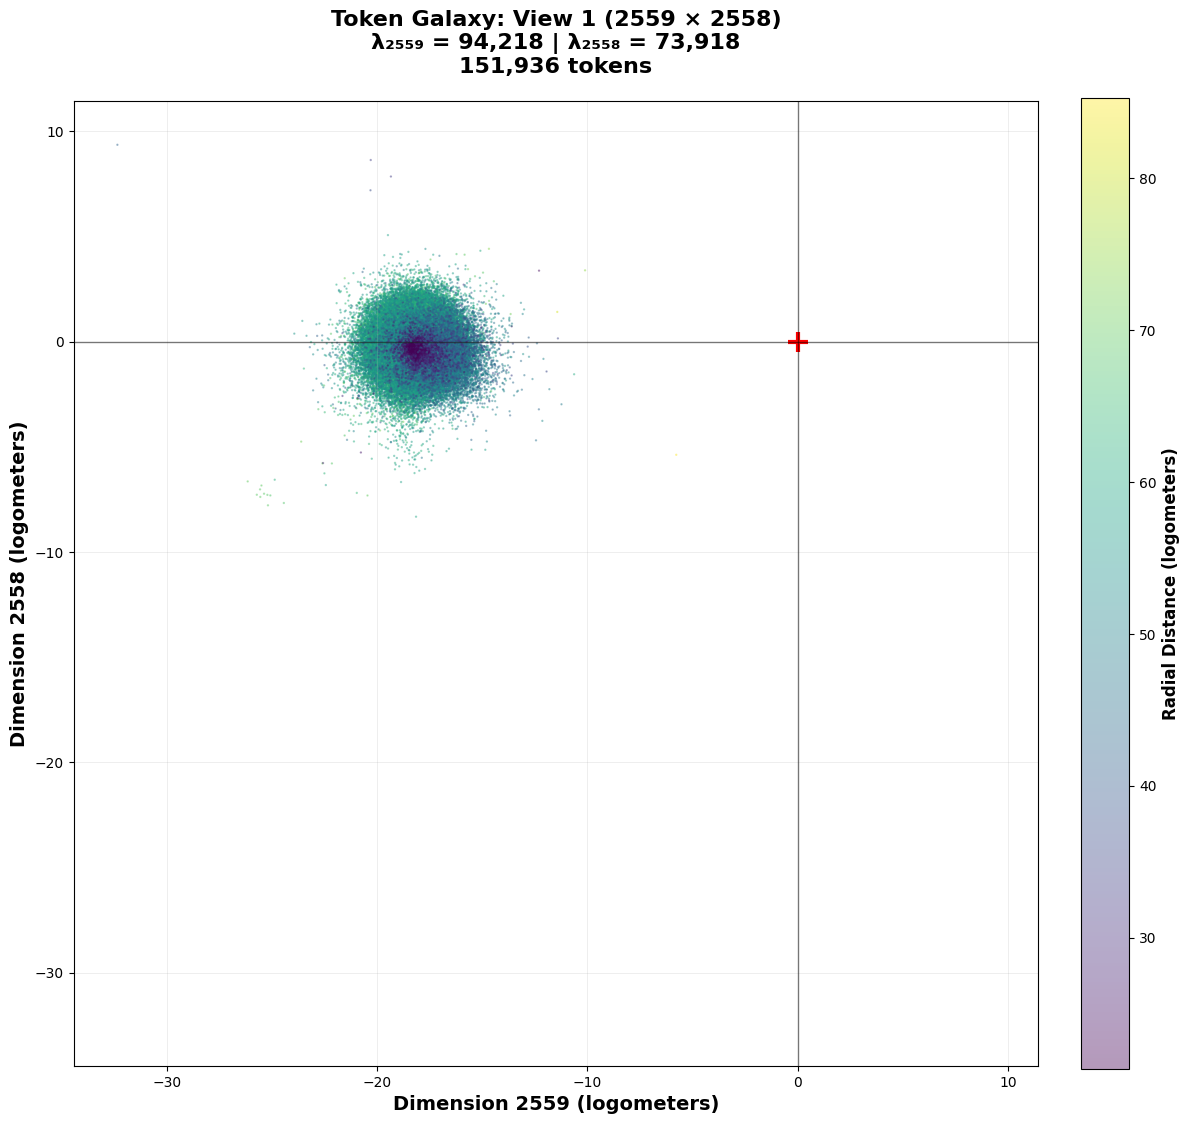


✓ Plot 1 complete


In [8]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Scatter plot
scatter = ax.scatter(
    r1, s1,
    s=POINT_SIZE,
    alpha=ALPHA,
    c=causal_norms,
    cmap=cmap,
    norm=norm,
    rasterized=True
)

# Mark origin
ax.plot(0, 0, 'r+', markersize=15, markeredgewidth=3)

# Set axis limits (same for both axes, square aspect)
ax.set_xlim(axis_min, axis_max)
ax.set_ylim(axis_min, axis_max)
ax.set_aspect('equal')

# Grid and axes
ax.grid(True, alpha=0.3, linewidth=0.5)
ax.axhline(0, color='black', linewidth=1, alpha=0.5)
ax.axvline(0, color='black', linewidth=1, alpha=0.5)

# Labels
ax.set_xlabel('Dimension 2559 (logometers)', fontsize=14, fontweight='bold')
ax.set_ylabel('Dimension 2558 (logometers)', fontsize=14, fontweight='bold')
ax.set_title(
    f'Token Galaxy: View 1 (2559 × 2558)\n'
    f'λ₂₅₅₉ = {eigenvalues[2559]:,.0f} | λ₂₅₅₈ = {eigenvalues[2558]:,.0f}\n'
    f'{vocab_size:,} tokens',
    fontsize=16,
    fontweight='bold',
    pad=20
)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Radial Distance (logometers)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 1 complete")

## PLOT 2: Dimensions 2559 × 0

Highest variance × lowest variance directions.

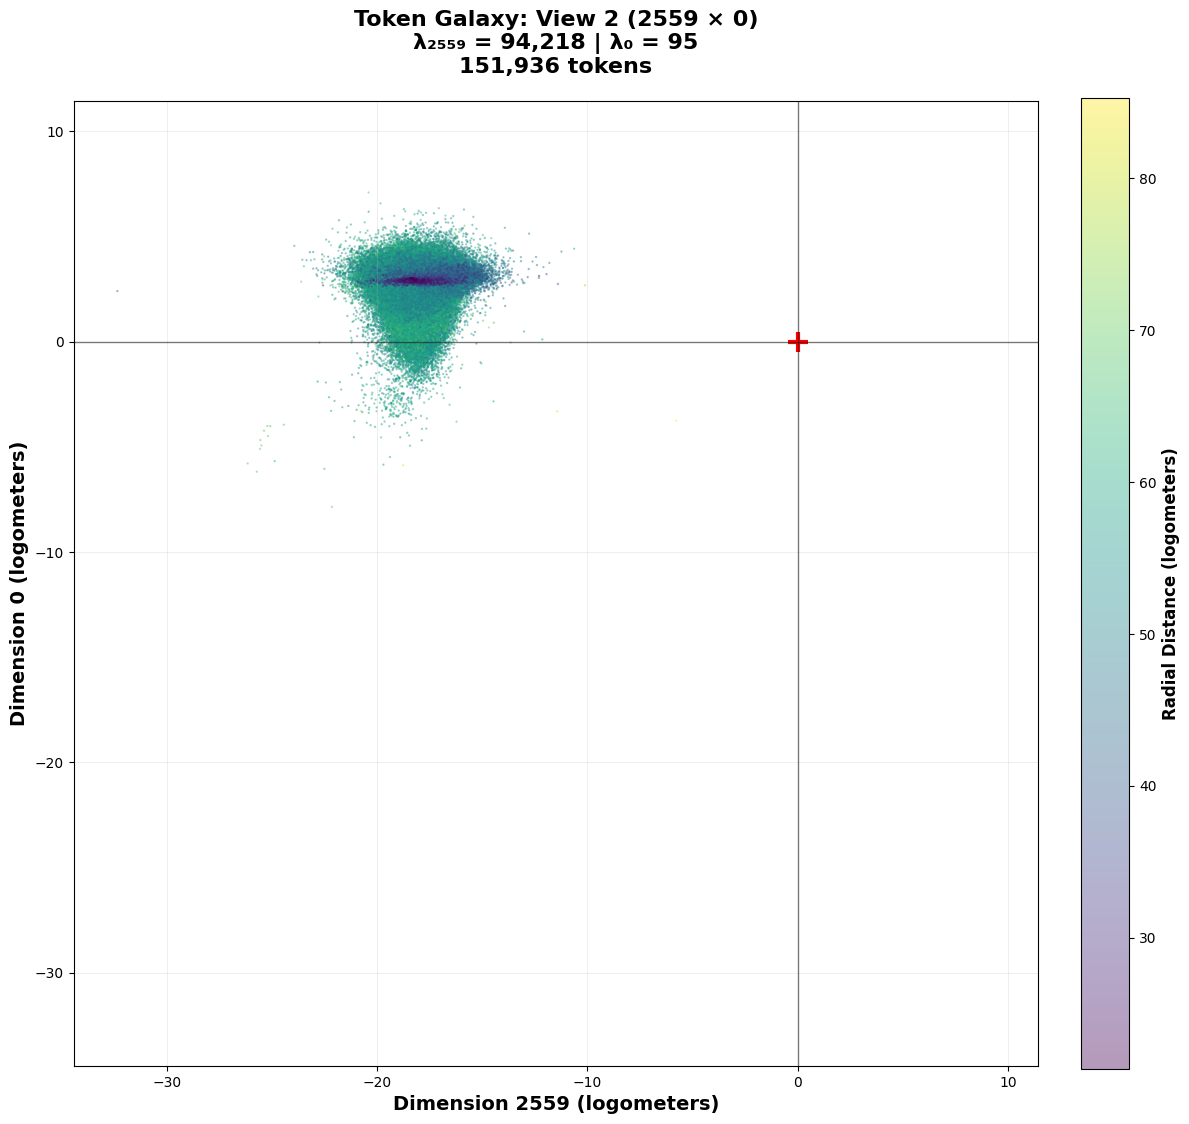


✓ Plot 2 complete


In [9]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Scatter plot
scatter = ax.scatter(
    r2, s2,
    s=POINT_SIZE,
    alpha=ALPHA,
    c=causal_norms,
    cmap=cmap,
    norm=norm,
    rasterized=True
)

# Mark origin
ax.plot(0, 0, 'r+', markersize=15, markeredgewidth=3)

# Set axis limits (SAME as plot 1 for consistent scale)
ax.set_xlim(axis_min, axis_max)
ax.set_ylim(axis_min, axis_max)
ax.set_aspect('equal')

# Grid and axes
ax.grid(True, alpha=0.3, linewidth=0.5)
ax.axhline(0, color='black', linewidth=1, alpha=0.5)
ax.axvline(0, color='black', linewidth=1, alpha=0.5)

# Labels
ax.set_xlabel('Dimension 2559 (logometers)', fontsize=14, fontweight='bold')
ax.set_ylabel('Dimension 0 (logometers)', fontsize=14, fontweight='bold')
ax.set_title(
    f'Token Galaxy: View 2 (2559 × 0)\n'
    f'λ₂₅₅₉ = {eigenvalues[2559]:,.0f} | λ₀ = {eigenvalues[0]:,.0f}\n'
    f'{vocab_size:,} tokens',
    fontsize=16,
    fontweight='bold',
    pad=20
)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Radial Distance (logometers)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 2 complete")

## Summary

**What you're seeing:**

Both plots show orthogonal projections of the 151,936-token cloud onto 2D planes:

- **Same scale:** 1 logometer = same pixel distance in both plots
- **Same axis limits:** Both use identical ranges so you can mentally overlay them
- **Same color map:** Purple = close to origin (~20-30 logometers), Yellow = far (~80+ logometers)

**Mental reconstruction:**
1. Plot 1 shows the galaxy viewed along the 2558 axis
2. Plot 2 shows the galaxy viewed along the 0 axis  
3. Both share dimension 2559 as the horizontal axis
4. You can imagine rotating from view 1 to view 2 by pivoting around the 2559 axis

**The spherical shell structure:**
- Color gradient shows radial stratification
- Most tokens cluster around 50-60 logometers (greenish)
- Outliers visible in purple (close) and yellow (far)
- The cloud is offset in the -2559 direction (negative x in both plots)